# import

In [ ]:
from torchvision import datasets, transforms
import torch

from efficientnet_pytorch import EfficientNet
from torch import nn
from torch.utils.data import DataLoader
import os
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from collections import Counter


In [3]:
out_dir = Path("..")
data_dir = "/home/clement/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
model_weightds = out_dir / "model_weights"

In [ ]:


print("Downloaded path:", data_dir)
p = Path(data_dir)

print("Top-level:", [x.name for x in p.iterdir()])

train_dirs = list(p.rglob("train"))
print("Found train dirs:", train_dirs[:10])


Downloaded path: /home/clement/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Top-level: ['val', '__MACOSX', 'test', 'chest_xray', 'train']
Found train dirs: [PosixPath('/home/clement/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train'), PosixPath('/home/clement/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train'), PosixPath('/home/clement/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/train')]


# Preprocess

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
train_dataset = datasets.ImageFolder(
    root = os.path.join(data_dir, "train"),
    transform = train_transform
)

eval_dataset = datasets.ImageFolder(
    root = os.path.join(data_dir, "val"),
    transform = eval_transform
)

test_dataset = datasets.ImageFolder(
    root = os.path.join(data_dir, "test"),
    transform = eval_transform
)



In [8]:

batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    pin_memory = True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026528388..0.8047843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026528388..0.989098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026528388..1.0087059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026528388..0.9381176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026528388..0.9067451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026528388..0.8675294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

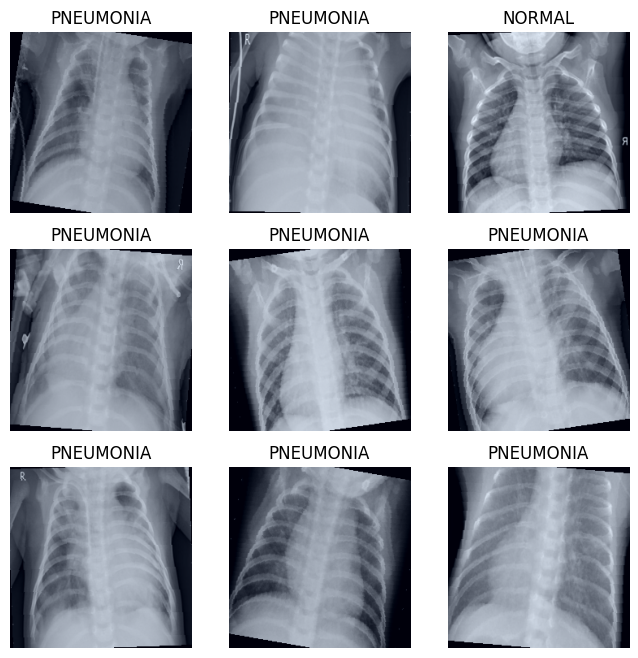

In [9]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = images[i].permute(1, 2, 0).numpy()
    img = img * 0.225 + 0.45  # dé-normalisation approximative
    plt.imshow(img)
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")
plt.show()


In [ ]:
import numpy as np

def get_labels(dataset):
    return np.array([y for _, y in dataset])

y_train = get_labels(train_dataset)
y_val = get_labels(eval_dataset)
y_test  = get_labels(test_dataset)


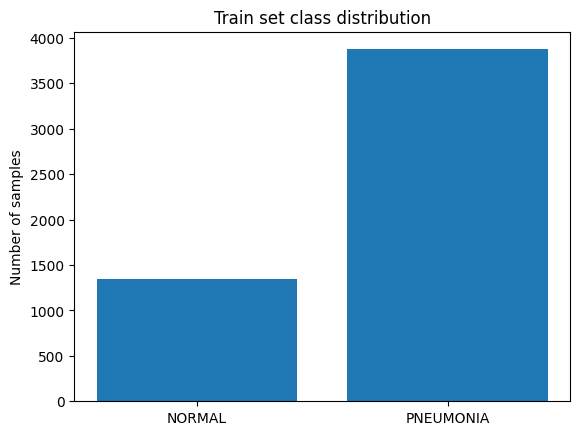

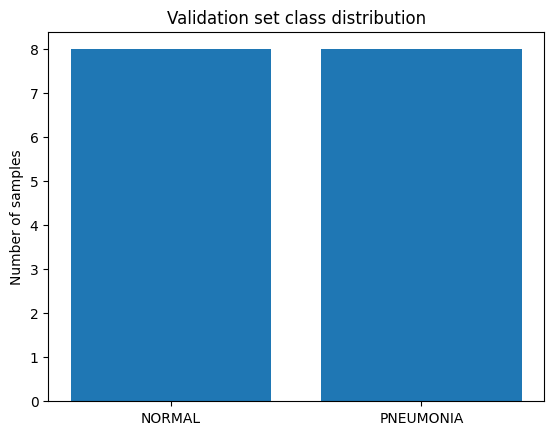

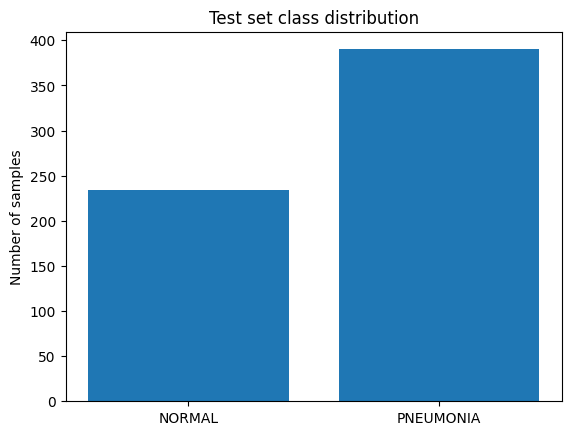

In [ ]:


def plot_class_distribution(y, title):
    counts = Counter(y)
    labels = list(counts.keys())
    values = list(counts.values())

    plt.bar(labels, values)
    plt.xticks(labels, ["NORMAL", "PNEUMONIA"])
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.show()

plot_class_distribution(y_train, "Train set class distribution")
plot_class_distribution(y_val,   "Validation set class distribution")
plot_class_distribution(y_test,  "Test set class distribution")


In [ ]:
print(train_dataset.class_to_idx)  

{'NORMAL': 0, 'PNEUMONIA': 1}


In [11]:
labels = [y for image, y in train_dataset]
labels = np.array(labels)

pos = (labels == 1).sum()
neg = (labels == 0).sum()

pos_neg_weight = torch.tensor([neg/pos])


# Def Model / Training loop

In [12]:
class Cnn_model(nn.Module):
    def __init__(self, n_classes=2, dropout=0.2, freeze_backbone=True, model_name="efficientnet-b0"):
        super(Cnn_model, self).__init__()
        self.base = EfficientNet.from_pretrained(model_name)
        in_features = self.base._fc.in_features  

        self.base._fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, n_classes)
        )

        if freeze_backbone:
            # freeze tout
            for p in self.base.parameters():
                p.requires_grad = False
            # unfreeze uniquement la tête
            for p in self.base._fc.parameters():
                p.requires_grad = True

    def forward(self, x):
        return self.base(x)


In [13]:
class EarlyStopping:
    def __init__(self, patience=5, mode="min"):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.count = 0

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return False  

        improved = (metric < self.best) if self.mode == "min" else (metric > self.best)

        if improved:
            self.best = metric
            self.count = 0
            return False
        else:
            self.count += 1
            return self.count >= self.patience


In [20]:
def training_model(model, train_loader, val_loader, device, optimizer, criterion):
    train_loss = []
    for batch in train_loader:
        optimizer.zero_grad()
        X, y = batch[0].to(device), batch[1].to(device).float().view(-1)
        logits = model(X).view(-1)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    return float(np.mean(train_loss))


@torch.no_grad()
def evaluate_model(model, val_loader, criterion, device, threshold = 0.5):
    model.eval()
    val_losses = []
    correct = 0
    total= 0
    all_probs, all_y = [], []
    for batch in val_loader:
        X, y = batch[0].to(device), batch[1].to(device).float().view(-1)
        logits = model(X).view(-1)
        val_loss = criterion(logits,y)
        preds = torch.sigmoid(logits)

        y_prob = (preds >= threshold).float()
        all_probs.append(y_prob.detach().cpu())
        all_y.append(y.detach().cpu())
        val_losses.append(val_loss.item())
        correct += (y_prob == y).sum().item()
        total += y.numel()

    all_probs = torch.cat(all_probs, dim=0).numpy().reshape(-1)
    all_y = torch.cat(all_y, dim=0).numpy().reshape(-1)

    return float(np.mean(val_losses)), correct / total, all_probs, all_y


def fit_epoch(model, train_loader, val_loader, device, criterion, optimizer, num_epoch, save_path="best_model.pt", patience= 5):
    es = EarlyStopping(patience=patience, mode="min")
    best_val = float("inf")
    train_losses, val_losses = [], []
    for epoch in range(num_epoch):
        train_loss = training_model(model, train_loader, val_loader, device, optimizer, criterion)
        val_loss, acc_val, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f" Epoch {epoch} - train loss : {train_loss} - val loss {val_loss} - acc val {acc_val}")
        
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            patience_left = patience
            torch.save(model.state_dict(), save_path)
        else:
            patience_left -= 1
            if patience_left <= 0:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val:.4f})")
                break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
    # reload best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    return model, train_losses, val_losses


@torch.no_grad()
def test(model, test_loader, device, criterion, threshold):
    te_loss, te_acc, y_probs, y_true = evaluate_model(model, test_loader,criterion, device, threshold)
    print(f"Test loss={te_loss:.4f} | Test acc={te_acc:.3f}")
    return te_loss, te_acc, y_true, y_probs



In [22]:
model = Cnn_model(n_classes = 1, dropout = 0.2, freeze_backbone = True, model_name = "efficientnet-b7")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
pos_weight = pos_neg_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-4)



Loaded pretrained weights for efficientnet-b7


# Train / Test

In [ ]:

model, train_loss, val_loss = fit_epoch(model, train_loader, eval_loader, device, criterion, optimizer, num_epoch = 30)


Loaded pretrained weights for efficientnet-b7
 Epoch 0 - train loss : 0.2595689929113155 - val loss 0.2917864918708801 - acc val 0.75
 Epoch 1 - train loss : 0.16543103136667392 - val loss 0.1728438436985016 - acc val 0.75
 Epoch 2 - train loss : 0.09958181239482833 - val loss 0.14730501174926758 - acc val 0.875
 Epoch 3 - train loss : 0.08655135924132859 - val loss 0.13848178088665009 - acc val 0.875
 Epoch 4 - train loss : 0.07697016936613292 - val loss 0.13357101380825043 - acc val 0.875
 Epoch 5 - train loss : 0.07446867391103651 - val loss 0.1266769915819168 - acc val 0.875
 Epoch 6 - train loss : 0.06945438746635507 - val loss 0.11994980275630951 - acc val 0.875
 Epoch 7 - train loss : 0.06595617632676916 - val loss 0.11861209571361542 - acc val 0.875
 Epoch 8 - train loss : 0.06294685238745154 - val loss 0.11141373217105865 - acc val 0.9375
 Epoch 9 - train loss : 0.05974398235358843 - val loss 0.11420975625514984 - acc val 0.875
 Epoch 10 - train loss : 0.06090887186185616 - va

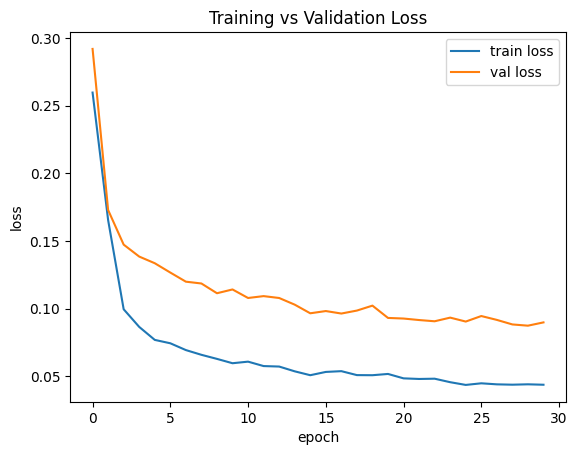

In [112]:
def plot_losses(train_loss, val_loss):
    plt.figure()
    plt.plot(train_loss, label="train loss")
    plt.plot(val_loss, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()
    
plot_losses(train_loss, val_loss)

In [30]:
def plot_roc_pr(y_true, y_proba, name="model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve - {name}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"roc_{name}.png", dpi=200)
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR curve - {name}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"pr_{name}.png", dpi=200)
    plt.show()

def show_confusion(y_true, y_proba, threshold=0.5, name="model"):
    y_pred = (y_proba >= threshold).astype(int)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format="d")
    plt.title(f"Confusion matrix - {name} : thr={threshold:.2f}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"cm_{name}_thr_{threshold:.2f}.png", dpi=200)
    plt.show()

In [ ]:
test_loss, test_acc, y_true, y_pred = test(model, test_loader, device,criterion, threshold = 0.5)

Test loss=0.2082 | Test acc=0.896


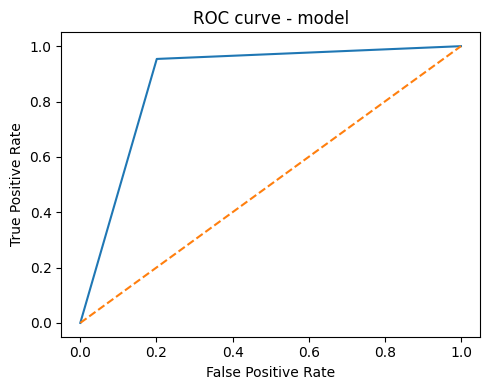

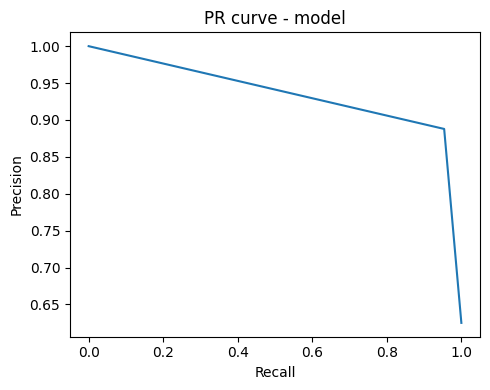

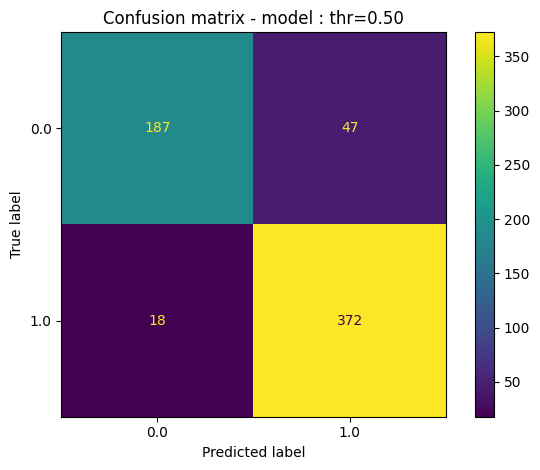

In [114]:
plot_roc_pr(y_true, y_pred)
show_confusion(y_true, y_pred)

In [25]:
model = Cnn_model(n_classes = 1, dropout = 0.2, freeze_backbone = True, model_name = "efficientnet-b7")
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()

Loaded pretrained weights for efficientnet-b7


Cnn_model(
  (base): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
 

In [ ]:

@torch.no_grad()
def predict_proba(model, loader, device):
    model.eval()
    y_true, y_proba = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X).view(-1)
        proba = torch.sigmoid(logits).detach().cpu().numpy()
        y_proba.append(proba)
        y_true.append(y.numpy())
    y_true = np.concatenate(y_true).astype(int).reshape(-1)
    y_proba = np.concatenate(y_proba).reshape(-1)
    return y_true, y_proba

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
y_test, p_test = predict_proba(model, test_loader, device)


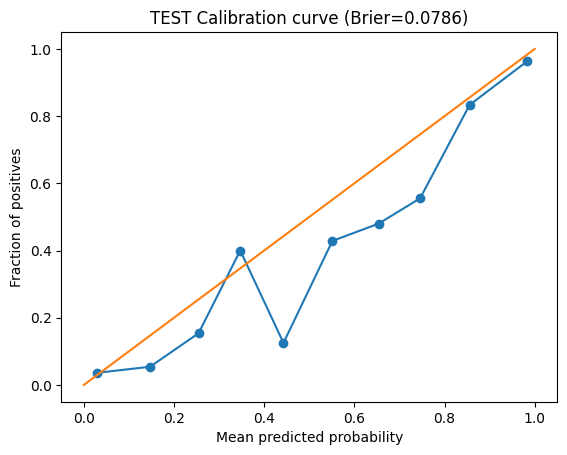

TEST Brier: 0.07855428755283356


In [ ]:


def plot_calibration(y, p, title=""):
    brier = brier_score_loss(y, p)
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=10, strategy="uniform")

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1])
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"{title} Calibration curve (Brier={brier:.4f})")
    plt.show()
    return brier

brier_test = plot_calibration(y_test, p_test, "TEST")
print("TEST Brier:", brier_test)
